# Исследование объявлений о продаже квартир


ПРОЕКТНАЯ РАБОТА - СПРИНТ 3

<a name="title"></a>
### Содержание

[Описание проекта](#info)
1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропусков](#null)
    * [Замена типа данных](#data_type)
3. [Подготовка таблицы](#tabl)
4. [Аналитика](#analitika)
    * [Параметры и гистограммы](#param)
    * [Задание: "Время продажи квартиры"](#time)
    * [Задание: "Редкие и выбивающиеся значения"](#del_param)
    * [Задание: "Факторы и стоимости квартиры"](#factor)
    * [Задание: "Средняя цена квадратного метра"](#sq_meter)
    * [Задание: "Центр"](#centre)
5. [Общий вывод](#general)

<a name="info"></a>
## Описание проекта
В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив
объявлений о продаже квартир в Санкт-Петербурге и соседних
населённых пунктах за несколько лет. 

**Цель** - научиться определять рыночную стоимость объектов недвижимости.

**Задача** - установить параметры. 

Это позволит построить автоматизированную
систему: она отследит аномалии и мошенническую деятельность.


**Данные предоставлены в формате csv, выборка содержит 23,7 тысячи записей.**

По каждой квартире на продажу доступны два вида данных. Первые
вписаны пользователем, вторые — получены автоматически на основе
картографических данных. Например, расстояние до центра, аэропорта,
ближайшего парка и водоёма.

[к содержанию...](#title)

<a name="start"></a>
## 1. Открытие данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


[к содержанию...](#title)

  <a name="preprocessing"></a>
  ## 2. Предобработка данных

<a name="null"></a>
## 2.1 Обработка пропусков

Начнем с порядка в названии столбцов:

In [3]:
df.set_axis(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'], axis = 'columns', inplace = True)

### days_exposition

Первоначальное предположение, что столбец 'days_exposition' логично заменить медианой и сохранить таким образом порядка 3 тысяч записей, привело к серьезным искажениям в дальнейшем анализе. 

Возможная причина пропусков - это то, что объявление еще находится в размещение, конечно это необходимо подтвердить с технарями, но на текущий момент, **верным решением будет удалить строки с пропущенными значениями**, так как незакрытая сделка не может гарантировать нам реальной рыночной цены. 

In [4]:
df.dropna(subset = ['days_exposition'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20518 entries, 1 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20518 non-null  int64  
 1   last_price            20518 non-null  float64
 2   total_area            20518 non-null  float64
 3   first_day_exposition  20518 non-null  object 
 4   rooms                 20518 non-null  int64  
 5   ceiling_height        12051 non-null  float64
 6   floors_total          20441 non-null  float64
 7   living_area           18813 non-null  float64
 8   floor                 20518 non-null  int64  
 9   is_apartment          2500 non-null   object 
 10  studio                20518 non-null  bool   
 11  open_plan             20518 non-null  bool   
 12  kitchen_area          18443 non-null  float64
 13  balcony               11109 non-null  float64
 14  locality_name         20470 non-null  object 
 15  airports_nearest   

### ceiling_height

In [5]:
df['ceiling_height'].describe()

count    12051.000000
mean         2.761805
std          1.263803
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Посмотрим глазками что у нас за чудеса питерской архитектуры с высотой потолков менее 2.1 (минимально допустимая высота по СНиП) и более 5 метров (для второго света в два этажа), а главное поймем их количество:

In [6]:
df[(df['ceiling_height'] < 2.1) | (df['ceiling_height'] > 5)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000.0,55.20,2018-07-12T00:00:00,2,25.00,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
464,15,66571000.0,280.30,2015-06-11T00:00:00,6,5.20,8.0,159.5,7,NaN,...,21.10,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
552,11,2999000.0,33.50,2017-03-30T00:00:00,1,2.00,15.0,17.5,6,NaN,...,6.50,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
1388,20,59800000.0,399.00,2015-01-21T00:00:00,5,5.60,6.0,NaN,6,NaN,...,NaN,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
3474,3,1400000.0,30.00,2018-03-16T00:00:00,1,8.00,5.0,15.3,2,False,...,7.30,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.6,9,NaN,...,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
4643,0,4300000.0,45.00,2018-02-01T00:00:00,2,25.00,9.0,30.0,2,NaN,...,7.00,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.00,2017-09-27T00:00:00,0,27.00,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000.0,30.50,2018-10-03T00:00:00,1,24.00,5.0,19.5,1,True,...,5.50,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000.0,54.00,2017-10-13T00:00:00,2,27.00,5.0,30.0,3,NaN,...,9.00,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0


Удаляем данные строки как явно ошибочные и незначительные в общем объеме. Скорее всего значения от 24 до 32 метров можно было бы принять за ошибку ввода и разделив на 10 получить адекватные значения высоты, но мы не можем быть в этом уверены и опять же их количество незначительно.

Чтобы не потерять пропуски нужно не забыть перед фильтрацией заменить их медианным значением... Индексы сбросим позже.

В дальнейшем при проведении анализа логичнее будет использовать категории: стандартный, высокий и основная масса попадет как раз в стандартный для высоты потолков диапазон до 2,7 метра.

In [7]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df = df.query('2.1 <= ceiling_height <= 5')

df['ceiling_height'].describe()

count    20479.000000
mean         2.690635
std          0.205390
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

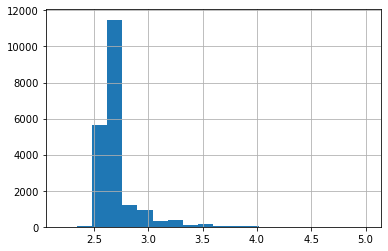

In [8]:
df['ceiling_height'].hist(bins=20)

### locality_name, floors_total

Замена пропусков в данных столбцах невозможна. Их сохранение вызовет проблемы в дальнейших расчетах и анализе, поэтому данные строки будут удалены.

In [9]:
df.dropna(subset = ['locality_name', 'floors_total'], inplace = True)

### living_area, kitchen_area

Учитывая большое количество пропусков в данных столбцах (living_area - 1666, kitchen_area - 2012), их удаление нецелесообразно.

Расчет площади кухни предлагаем провести исходя из общей площади и коэффициента (kitchen_area/total_area),

а для расчета недостающей жилой площади взять отношение жилой площади и количества комнат в строках без пропусков

In [10]:
df['kitchen_area'].isna().sum()

2012

In [11]:
df['living_area'].isna().sum()

1666

In [12]:
df['k_kitchen_area'] = df['kitchen_area'] / df['total_area']

In [13]:
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']*df['k_kitchen_area'].median())

In [14]:
df['k_rooms'] = df['living_area'] / df['rooms']

In [15]:
df['living_area'] = df['living_area'].fillna(df['rooms']*df['k_rooms'].median())

### airports_nearest, city_centers_nearest, parks_nearest, ponds_nearest

Обнулить пропуски в данных столбцах будет некорректно, так как "0" скажет нам о максимальной близости к объекту... Поэтому вариант первый - удалить строки, но жалко, выкинем большой объем, вариант два - заменить в идеале на бесконечность или в нашем случае хотя бы на 100 км. При необходимости мы сможем всегда отфильтровать их.

In [16]:
df[df['ponds_nearest'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,k_kitchen_area,k_rooms
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,NaN,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.272277,18.600000
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,NaN,...,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,0.299342,14.400000
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.60,6,NaN,...,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,0.386059,10.600000
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,NaN,...,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,0.265682,15.430000
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,0.106557,14.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,6,3200000.0,39.00,2017-12-16T00:00:00,1,2.65,9.0,20.00,6,NaN,...,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0,0.282051,20.000000
23688,19,9200000.0,101.00,2019-04-01T00:00:00,3,3.05,15.0,63.00,12,NaN,...,Санкт-Петербург,15632.0,14428.0,0.0,NaN,0.0,NaN,23.0,0.148515,21.000000
23690,3,5500000.0,52.00,2018-07-19T00:00:00,2,2.65,5.0,31.00,2,NaN,...,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0,0.115385,15.500000
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5.0,17.50,4,NaN,...,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0,0.200000,17.500000


In [17]:
df[(df.parks_nearest.isna()) & (df.parks_around3000 > 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,k_kitchen_area,k_rooms


In [18]:
df[(df.ponds_nearest.isna()) & (df.ponds_around3000 > 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,k_kitchen_area,k_rooms


In [19]:
for column in ['airports_nearest', 
               'city_centers_nearest',
               'parks_nearest', 
               'ponds_nearest']:
    df[column] = df[column].fillna(100000)

### 'is_apartment, balcony, parks_around3000,  ponds_around3000

В отличии от расстояний в данных столбцах ноль вместо пропусков как раз таки логичен и обоснован, но на всякий случай проверим условие не пересекается ли пропуск в 'parks_around3000' и 'ponds_around3000' со значением меньшим 3000 метров в соседнем столбце. Если нет то смело зануляем...

In [20]:
df[(df.parks_nearest <= 3000) & (df.parks_around3000.isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,k_kitchen_area,k_rooms


In [21]:
df[(df.ponds_nearest <= 3000) & (df.ponds_around3000.isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,k_kitchen_area,k_rooms


In [22]:
for column in ['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000']:
    df[column] = df[column].fillna(0)

[к содержанию...](#title)

<a name="data_type"></a>
## 2.2 Замена типа данных

### first_day_exposition
Для облегчения дальнейшей обработки переведем столбец 'first_day_exposition' к типу **datetime**

In [23]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

### float к int
Переведем следующие столбцы с типом float к типу int:

In [24]:
bed_type_columns = ['last_price', 'floors_total', 'balcony', 'airports_nearest',
                    'city_centers_nearest', 'parks_around3000',
                    'parks_nearest', 'ponds_around3000',
                    'ponds_nearest', 'days_exposition']

In [25]:
for column in bed_type_columns:
    df[column] = df[column].astype('int')

### object к bool

In [26]:
df['is_apartment'] = df['is_apartment'].astype('bool')

## Оценим результат:

In [27]:
df.duplicated().sum()

0

In [28]:
df = df.reset_index(drop=True)
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,k_kitchen_area,k_rooms
count,20355.000000,2.035500e+04,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,20355.000000,18343.000000,18689.0
mean,9.633161,6.256058e+06,58.820770,2.024761,2.690616,10.863817,33.445725,5.973766,10.345025,0.593810,45079.930926,33757.877622,0.463719,66400.128077,0.586834,61845.535200,180.763989,0.189230,inf
std,5.655924,1.085476e+07,33.958494,1.054744,0.205605,6.646200,20.947996,4.932182,5.774308,0.949641,31880.781521,36686.120197,0.744504,47060.465371,0.878803,48373.102039,219.793773,0.072619,NaN
min,0.000000,1.219000e+04,12.000000,0.000000,2.200000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.025381,1.0
25%,6.000000,3.400000e+06,39.525000,1.000000,2.600000,5.000000,18.000000,2.000000,7.000000,0.000000,20937.000000,11004.000000,0.000000,607.000000,0.000000,640.000000,45.000000,0.135185,14.5
50%,9.000000,4.500000e+06,50.800000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,33531.000000,14978.000000,0.000000,100000.000000,0.000000,100000.000000,95.000000,0.175000,16.0
75%,14.000000,6.500000e+06,67.800000,3.000000,2.700000,16.000000,42.000000,8.000000,11.800000,1.000000,53520.000000,34156.000000,1.000000,100000.000000,1.000000,100000.000000,231.000000,0.234375,18.0
max,50.000000,7.630000e+08,900.000000,19.000000,5.000000,60.000000,409.700000,33.000000,112.000000,5.000000,100000.000000,100000.000000,3.000000,100000.000000,3.000000,100000.000000,1580.000000,0.787879,inf


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20355 entries, 0 to 20354
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20355 non-null  int64         
 1   last_price            20355 non-null  int64         
 2   total_area            20355 non-null  float64       
 3   first_day_exposition  20355 non-null  datetime64[ns]
 4   rooms                 20355 non-null  int64         
 5   ceiling_height        20355 non-null  float64       
 6   floors_total          20355 non-null  int64         
 7   living_area           20355 non-null  float64       
 8   floor                 20355 non-null  int64         
 9   is_apartment          20355 non-null  bool          
 10  studio                20355 non-null  bool          
 11  open_plan             20355 non-null  bool          
 12  kitchen_area          20355 non-null  float64       
 13  balcony         

[к содержанию...](#title)

<a name="tabl"></a>
## 3. Подготовка таблицы

### Цена квадратного метра

In [30]:
df['sq_price'] = df['last_price'] / df['total_area']
df['sq_price'] = df['sq_price'].astype('int')

### День недели, месяц и год публикации

In [31]:
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

### Этаж (категория)

In [32]:
for i in range(len(df)):
    floor = df.loc[i, 'floor']
    total = df.loc[i, 'floors_total']
    if floor == 1:
        type = 'first'
    if 1 < floor < total:
        type = 'other'
    if floor == total:
        type = 'last'
    df.loc[i, 'floor_type'] = type

### Соотношение площадей

In [33]:
df['k_living_area '] = df['living_area'] / df['total_area']
df['k_kitchen_area'] = df['kitchen_area'] / df['total_area']

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20355 entries, 0 to 20354
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20355 non-null  int64         
 1   last_price            20355 non-null  int64         
 2   total_area            20355 non-null  float64       
 3   first_day_exposition  20355 non-null  datetime64[ns]
 4   rooms                 20355 non-null  int64         
 5   ceiling_height        20355 non-null  float64       
 6   floors_total          20355 non-null  int64         
 7   living_area           20355 non-null  float64       
 8   floor                 20355 non-null  int64         
 9   is_apartment          20355 non-null  bool          
 10  studio                20355 non-null  bool          
 11  open_plan             20355 non-null  bool          
 12  kitchen_area          20355 non-null  float64       
 13  balcony         

### Цена в миллионах рублей
Для удобства продублируем столбец 'last_price' в миллионах рублей - 'price_mln'

In [35]:
df['price_mln'] = df['last_price'] / 1000000

[к содержанию...](#title)

<a name="analitika"></a>
## 4. Аналитика

Проведем анализ заданных параметров на предмет их реалистичности, для этого сделаем выводы на основании их распределений, гистограмм и здравого смысла.

<a name="param"></a>
### 4.1 Параметры и гистограммы

Подготовим функцию принимающую на вход название столбца и возвращающую бокс, гистограмму и описание распределения:

In [36]:
def p_h(column):
    print(df[column].describe())
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], ax=ax_box)
    sns.distplot(df[column], ax=ax_hist, hist=True, kde=False)
    ax_box.set(xlabel='')
    plt.show()
   

#### Площадь

count    20355.000000
mean        58.820770
std         33.958494
min         12.000000
25%         39.525000
50%         50.800000
75%         67.800000
max        900.000000
Name: total_area, dtype: float64


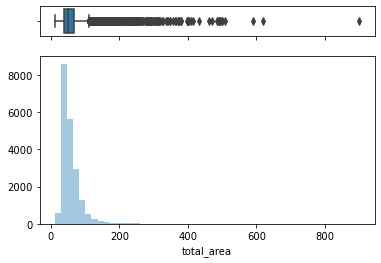

In [37]:
p_h('total_area')

"Осмотрим" объекты площадью свыше 400 кв.м.

In [38]:
df.query('total_area > 400')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,k_kitchen_area,k_rooms,sq_price,weekday_exposition,month_exposition,year_exposition,floor_type,k_living_area,price_mln
558,3,49950000,483.9,2017-10-04,7,3.20,6,312.5,4,False,...,391,0.054557,44.642857,103223,2,10,2017,other,0.645795,49.950000
4592,20,65000000,590.0,2019-02-14,15,3.50,6,409.0,3,False,...,14,0.169492,27.266667,110169,3,2,2019,other,0.693220,65.000000
5046,3,230000000,500.0,2017-05-31,6,2.65,7,96.0,7,False,...,50,0.080000,NaN,460000,2,5,2017,last,0.192000,230.000000
5318,8,34000000,470.3,2018-01-14,4,2.65,3,248.7,3,False,...,179,0.085052,62.175000,72294,6,1,2018,last,0.528811,34.000000
5670,20,99000000,488.0,2017-04-09,5,2.95,20,216.0,17,False,...,351,0.102459,43.200000,202868,6,4,2017,other,0.442623,99.000000
6892,20,84000000,507.0,2015-12-17,5,4.45,7,301.5,7,True,...,1078,0.089744,60.300000,165680,3,12,2015,last,0.594675,84.000000
8444,1,43185328,494.1,2017-05-12,1,2.85,12,16.0,3,False,...,5,0.175000,NaN,87401,4,5,2017,other,0.032382,43.185328
10648,20,91500000,495.0,2017-06-19,7,4.65,7,347.5,7,False,...,14,0.050505,49.642857,184848,0,6,2017,last,0.702020,91.500000
11809,7,240000000,410.0,2017-04-01,6,3.40,7,218.0,7,False,...,199,0.097561,36.333333,585365,5,4,2017,last,0.531707,240.000000
12104,8,51000000,402.0,2017-02-07,6,3.15,8,300.0,6,False,...,32,0.139303,50.000000,126865,1,2,2017,other,0.746269,51.000000


### Вывод:
**Аномалий не обнаружено, распределение логично**.

**Сверхнизкие** *(доля в квартире)* и **сверхвысокие** *(12 комнатная квартира с бассейном на 400 кв.м)* значения данного параметра **имеют место быть в сфере недвижимости**.

#### Цена

count    2.035500e+04
mean     6.256058e+06
std      1.085476e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.500000e+06
75%      6.500000e+06
max      7.630000e+08
Name: last_price, dtype: float64


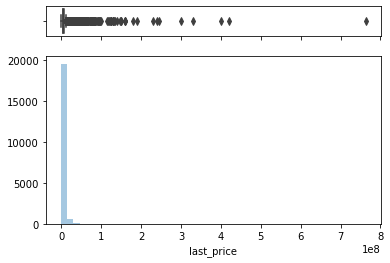

In [39]:
p_h('last_price')

Оценим распределения попадающие в зону верхних выбросов.

In [40]:
#df.query('last_price > ((6.5-3.47)*1.5+6.5)').describe()

### Вывод:
**Аномалий не обнаружено, распределение логично**. 

Осмотр строк с экстремальными значениями поводов для размышления не дает. Рассуждения аналогичны параметру "Площадь".

#### Число комнат

count    20355.000000
mean         2.024761
std          1.054744
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


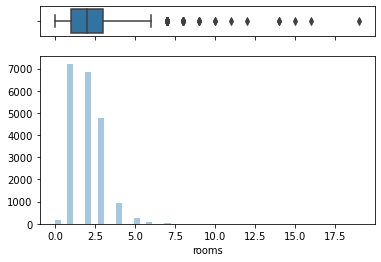

In [41]:
p_h('rooms')

In [42]:
df.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,k_kitchen_area,k_rooms,sq_price,weekday_exposition,month_exposition,year_exposition,floor_type,k_living_area,price_mln
123,1,2450000,27.00,2017-03-30,0,2.65,24,15.50,2,False,...,181,0.175,inf,90740,3,3,2017,other,0.574074,2.450
289,4,2320000,25.00,2017-09-27,0,2.65,14,17.00,1,False,...,45,0.175,inf,92800,2,9,2017,first,0.680000,2.320
370,8,2480000,27.11,2018-03-12,0,2.65,17,24.75,4,False,...,64,0.175,inf,91479,0,3,2018,other,0.912947,2.480
430,0,3375000,34.40,2017-03-28,0,2.65,26,24.30,19,False,...,430,0.175,inf,98110,1,3,2017,other,0.706395,3.375
515,2,1850000,25.00,2019-02-20,0,2.65,10,0.00,7,False,...,29,0.175,NaN,74000,2,2,2019,other,0.000000,1.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19936,7,3200000,26.00,2017-09-01,0,2.65,25,18.00,16,False,...,14,0.175,inf,123076,4,9,2017,other,0.692308,3.200
20136,0,2500000,27.70,2017-09-28,0,2.65,24,18.00,4,False,...,4,0.175,inf,90252,3,9,2017,other,0.649819,2.500
20232,15,3350000,26.00,2018-09-07,0,2.65,19,0.00,8,False,...,31,0.175,NaN,128846,4,9,2018,other,0.000000,3.350
20265,10,1450000,29.00,2017-11-11,0,2.65,9,18.00,8,False,...,82,0.175,inf,50000,5,11,2017,other,0.620690,1.450


In [43]:
df['rooms'].where(df['rooms']!=0, 1, inplace=True)

# Вывод:
**178 нулевых значений заменены на 1, распределение логично**. 

Осмотр строк с экстремальными значениями поводов для размышления не дает. Рассуждения аналогичны параметру "Площадь".

#### Высота потолков

count    20355.000000
mean         2.690616
std          0.205605
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64


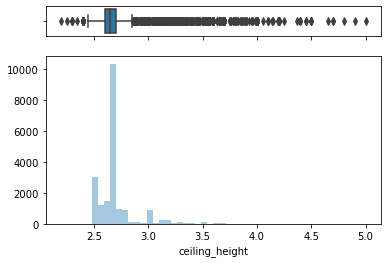

In [44]:
p_h('ceiling_height')

**Пик на 2.65 мы устроили сами, заменив пропуски.**
В принципе это не влияет на общую картину, к тому же куда **интереснее посмотреть на данные в следующем виде:**

In [45]:
df['potolok'] = pd.cut(df['ceiling_height'], (0,2.7,3,3.5,5))

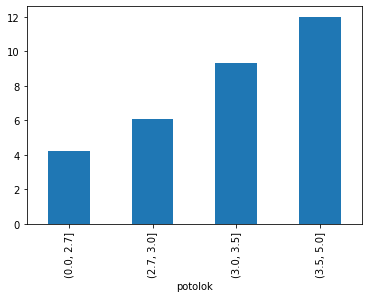

In [46]:
df.groupby('potolok')['price_mln'].median().plot(kind='bar')

In [47]:
df.groupby('potolok')['price_mln'].agg(['count', 'mean'])

,count,mean
potolok,,
"(0.0, 2.7]",16132,5.205146
"(2.7, 3.0]",3072,8.141530
"(3.0, 3.5]",944,14.692054
"(3.5, 5.0]",207,21.703164


### Вывод:
**Распределение логично**. 

Анализ и обработку данного параметра мы провели в начале исследования.

[к содержанию...](#title)

<a name="time"></a>
### 4.2 Задание: "Время продажи квартиры"

In [48]:
df['days_exposition'].describe()

count    20355.000000
mean       180.763989
std        219.793773
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

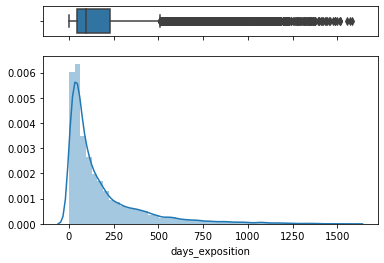

In [49]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df["days_exposition"], ax=ax_box)
sns.distplot(df["days_exposition"], ax=ax_hist, hist=True, kde=True)
ax_box.set(xlabel='')
plt.show()

### Вывод:
0. **Распределение "Времени размещения"** соответствует **распределению Пуассона** на всем диапазоне значений (даже в максимальных точках). Относить максимальные значения к выбросам и исключать их из анализа будет некорректно, хотя и очень хочется. 
1. **Среднее** значение "Времени размещения" составляет **181 день**.
2. **Медиана** "Времени размещения" равна **95 дней**. *(в данном случае наиболее информативна)*
3. **Обычным временем продажи** будем считать *межквартильный размах*, т.е. **диапазон 1.5 - 8 месяцев**. Исходя из этого **быстрой продажей** можно считать продажу в **первые 45 дней**, а **долгой - свыше 231 дней**.

Так же в ходе анализа **установлено влияние** на данный показатель **географии** размещения объекта. Но в рамках имеющихся данных однозначные выводы сделать нельзя. 

Например: **пгт Форносово** может реально оказаться **"золотым" местом** где недвижимость разлетается как горячие пирожки. А вот **поселок Лисий нос** *(— конечная точка маршрута главного героя повести Даниила Хармса «Старуха»)* может и не пользоваться на рынке недвижимости популярностью.


In [50]:
df.groupby('locality_name')['days_exposition'].mean().sort_values(ascending=False)

locality_name
поселок Севастьяново                 1069.0
деревня Рабитицы                     1007.0
посёлок Молодёжное                    786.0
поселок Коробицыно                    750.0
посёлок Лисий Нос                     717.5
                                      ...  
коттеджный поселок Счастье              7.0
садовое товарищество Садко              7.0
поселок Володарское                     5.0
поселок Заводской                       5.0
посёлок городского типа Форносово       3.0
Name: days_exposition, Length: 328, dtype: float64

[к содержанию...](#title)

<a name="del_param"></a>
## 4.3 Задание: "Редкие и выбивающиеся значения"

Проанализировав параметры:
- Площадь
2. Цена
3. Количество комнат
4. Высота потолков 
5. Время продажи квартиры

можно сделать следующие **выводы**:

**1. Однозначной корректировке подлежат только значения в столбце "высота потолков".** Удаляем значения **менее 2.1** *(минимум по СНиП)* **и более 5 метров** *(для второго света в студии)*. 

Удаляем данные строки как явно ошибочные и незначительные в общем объеме (менее 50 строк). Скорее всего значения от 24 до 32 метров можно было бы принять за ошибку ввода и разделив на 10 получить адекватные значения высоты, но мы не можем быть в этом уверены, а их количество менее 10.

Чтобы не потерять пропуски нужно не забыть перед фильтрацией заменить их медианным значением.

-------------------------------------------------------------------------------------------------------------

**2. Значение параметров Цена, Количество комнат, Высота потолков** корректировки не подлежат.
**Их распределения логичны и имеют место быть в сфере недвижимости**.

Например: для "Площади" - **Сверхнизкие** *(доля в квартире)* и **сверхвысокие** *(12 комнатная квартира с бассейном на 400 кв.м)* 

--------------
**3. Распределение "Времени размещения"** соответствует **распределению Пуассона** на всем диапазоне значений (даже в максимальных точках). Относить максимальные значения к выбросам и исключать их из анализа будет некорректно. 

Так же в ходе анализа **установлено влияние** на данный показатель **географии** размещения объекта. Но в рамках имеющихся данных однозначные выводы сделать нельзя. 

Например: **пгт Форносово** может реально оказаться **"золотым" местом** где недвижимость разлетается как горячие пирожки. А вот **поселок Лисий нос** *(— конечная точка маршрута главного героя повести Даниила Хармса «Старуха»)* может и не пользоваться на рынке недвижимости популярностью.


[к содержанию...](#title)

<a name="factor"></a>
## 4.4 Задание: "Факторы стоимости квартиры

Проведем предварительный анализ определив наиболее весомые зависимости, который затем рассмотрим подробнее.

Подготовим списки столбцов и сформируем датафреймы для них. Выделим временнЫе параметры в отдельный список.

In [51]:
#df.columns

In [52]:
work_columns_1 = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'balcony', 'locality_name', 'airports_nearest', 'city_centers_nearest',
                'parks_around3000', 'ponds_around3000', 'sq_price', 'floor_type', 'k_living_area ', 'k_kitchen_area']
work_columns_2 = ['last_price', 'sq_price', 'days_exposition', 'weekday_exposition',
       'month_exposition', 'year_exposition']

data_1 = df[work_columns_1]
data_2 = df[work_columns_2]
data_1.head()

,last_price,total_area,rooms,ceiling_height,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,ponds_around3000,sq_price,floor_type,k_living_area,k_kitchen_area
0,3350000,40.4,1,2.65,2,посёлок Шушары,12817,18603,0,0,82920,first,0.460396,0.272277
1,5196000,56.0,2,2.65,0,Санкт-Петербург,21741,13933,1,2,92785,other,0.612500,0.148214
2,64900000,159.0,3,2.65,0,Санкт-Петербург,28098,6800,2,3,408176,other,0.301887,0.175000
3,10000000,100.0,2,3.03,0,Санкт-Петербург,31856,8098,2,1,100000,other,0.320000,0.410000
4,2890000,30.4,1,2.65,0,городской посёлок Янино-1,100000,100000,0,0,95065,other,0.473684,0.299342


In [53]:
data_1.corr()

,last_price,total_area,rooms,ceiling_height,balcony,airports_nearest,city_centers_nearest,parks_around3000,ponds_around3000,sq_price,k_living_area,k_kitchen_area
last_price,1.000000,0.642119,0.354950,0.267279,0.013684,-0.154242,-0.194304,0.179178,0.194927,0.737186,-0.027923,-0.074515
total_area,0.642119,1.000000,0.762457,0.388909,0.017122,-0.144229,-0.189162,0.193987,0.199424,0.305339,0.095712,-0.299693
rooms,0.354950,0.762457,1.000000,0.238879,-0.010277,-0.123327,-0.144186,0.153689,0.121513,0.054625,0.486990,-0.560900
ceiling_height,0.267279,0.388909,0.238879,1.000000,-0.040204,-0.139473,-0.177899,0.238839,0.213115,0.274943,-0.029038,0.004529
balcony,0.013684,0.017122,-0.010277,-0.040204,1.000000,0.024885,0.021097,-0.067612,-0.032559,0.029569,-0.071479,0.042191
airports_nearest,-0.154242,-0.144229,-0.123327,-0.139473,0.024885,1.000000,0.933221,-0.310576,-0.353204,-0.385762,-0.009360,0.048789
city_centers_nearest,-0.194304,-0.189162,-0.144186,-0.177899,0.021097,0.933221,1.000000,-0.358594,-0.366598,-0.450439,0.013304,0.040241
parks_around3000,0.179178,0.193987,0.153689,0.238839,-0.067612,-0.310576,-0.358594,1.000000,0.390467,0.276463,0.058030,-0.084369
ponds_around3000,0.194927,0.199424,0.121513,0.213115,-0.032559,-0.353204,-0.366598,0.390467,1.000000,0.294489,-0.028089,-0.022473
sq_price,0.737186,0.305339,0.054625,0.274943,0.029569,-0.385762,-0.450439,0.276463,0.294489,1.000000,-0.175777,0.147229


#### Предварительные наблюдения:
**Цена зависит от:** 
- sq_price(0.74)
- total_area(0,64)
- rooms(0.35)
- ceiling_height(0.27)
- ponds_around3000(0.19)
- parks_around3000(0.18)
- city_centers_nearest(-0.19)
- airports_nearest(-0.15)	

Проверим не внесли ли мы погрешность в показатели *city_centers_nearest* и *airports_nearest*, заполнив пропуски значением 100км...

In [54]:
work_data_3 = ['last_price', 'airports_nearest', 'city_centers_nearest']
data_3 = df[work_data_3]
#data_3 = data_3.query('city_centers_nearest !=100000') 
data_3 = data_3.query('airports_nearest !=100000')
data_3.corr()

,last_price,airports_nearest,city_centers_nearest
last_price,1.000000,-0.024606,-0.192258
airports_nearest,-0.024606,1.000000,0.272557
city_centers_nearest,-0.192258,0.272557,1.000000


На расстояние до центра мы не повлияли, а вот аэропорт серьезно "пострадал":
- airports_nearest(-0.02) *- учтем это.* 

Интересно, что корреляции практически нет... Видимо плюсы доступности компенсируются минусами шумности)))



### Рассмотрим подробнее наиболее влиящией на стоимость величины:

### Цена квадратного метра

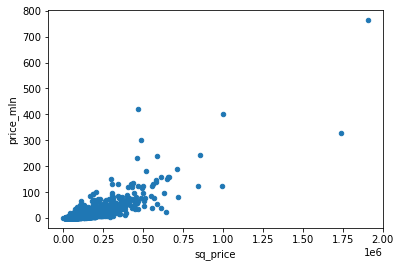

In [55]:
df.plot(x='sq_price', y='price_mln', kind='scatter')
plt.show()

#### Вывод:
Вполне ожидаемая корреляциия учитывая прямую связь этих параметров через площадь.

Это мало интересно и не информативно, лучше выйдем за рамки задания и рассмотрим **зависимость цены квадратного метра от площади**:

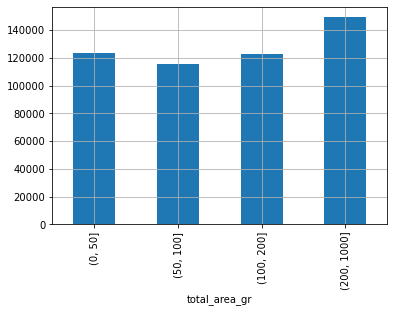

In [56]:
df['total_area_gr'] = pd.cut(df['total_area'], [0, 50, 100, 200,1000])
(
df.groupby('total_area_gr')['sq_price']
  .median()
  .plot(kind='bar', grid=True)
)
(
df.query('city_centers_nearest <= 9000').groupby('total_area_gr')['sq_price']
  .median()
  .plot(kind='bar', grid=True)
)
plt.show()

Тоже обыденно, но зато информативно и красиво... 

**Квадратный метр в 3-4х комнатных квартирах всегда стОит чуть меньше двушек и однушек, а далее наблюдаем резкий рост обусловленный переходом в премиум сегмент.**

## Площадь

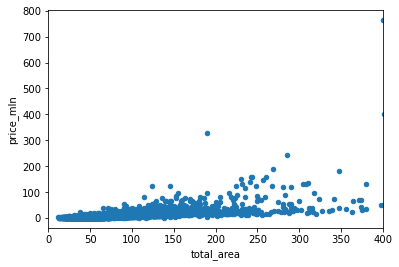

In [57]:
df.plot(x='total_area', y='price_mln', kind='scatter', xlim=[0, 400])
plt.show()

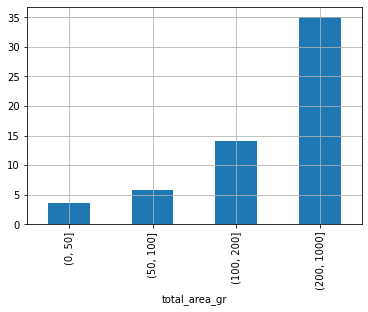

In [58]:
(
df.groupby('total_area_gr')['price_mln']
  .median()
  .plot(kind='bar', grid=True)
)
plt.show()

#### Вывод:
"Вот и выбирай, по пять, очень большие, но вчера, либо по три, маленькие, но сегодня, понял?" (Михаил Жванецкий)

(((

## Комнаты

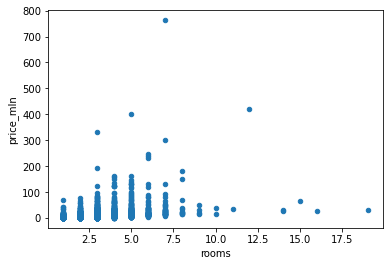

In [59]:
df.plot(x='rooms', y='price_mln', kind='scatter')
plt.show()

In [60]:
df.groupby('rooms')['price_mln'].median()

rooms
1       3.5500
2       4.7000
3       6.0500
4       8.8000
5      13.3000
6      19.0000
7      24.9000
8      24.0000
9      24.2500
10     27.7500
11     33.0000
12    420.0000
14     26.8295
15     65.0000
16     28.5000
19     32.2500
Name: price_mln, dtype: float64

### Наиболее информативно будет перевести количество комнат из непрерывной величины к категории.

**Рассмотрим группы 1, 2, 3, 4, 5, 5+ комнат:**

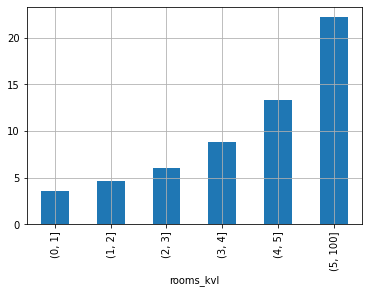

In [61]:
df['rooms_kvl'] = pd.cut(df['rooms'], [0,1,2,3,4,5,100])
(
df.groupby('rooms_kvl')['price_mln']
  .median()
  .plot(kind='bar', grid=True)
)
plt.show()

#### Вывод:
Яркая выраженность данной зависимости обусловлена в первую очередь **ростом площади объектов по мере роста количества комнат и усиливается ростом цены квадратного метра по мере роста самой площади**.


# Этажи

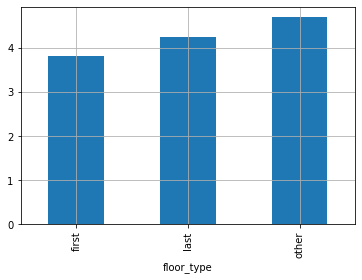

In [62]:
(df.groupby('floor_type')['price_mln']
   .median()
   .plot(kind='bar', grid=True)
)
plt.show()

In [63]:
df.groupby('floor_type')['price_mln'].median()

floor_type
first    3.817262
last     4.250000
other    4.700000
Name: price_mln, dtype: float64

#### Вывод:

In [64]:
print('Цена первого этажа ниже на {:.0%}'.format((390-475)/475))
print('Цена последнего этажа ниже на {:.0%}'.format((430-475)/475))

Цена первого этажа ниже на -18%
Цена последнего этажа ниже на -9%


**Классическая картина - "нехороших" квартир**. Обычно в основные минусы первого и последнего этажа записывают безопасность, близость подвала и крыши. Фору последнему этажу дают освещенность, более свежий воздух и техэтаж в современных домах.

# Парки и пруды

#### Пруды:

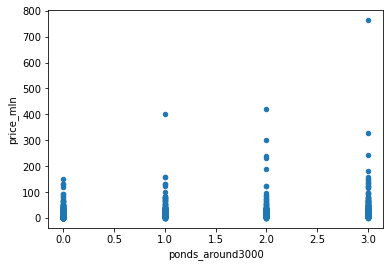

In [65]:
df.plot(x='ponds_around3000', y='price_mln', kind='scatter')
plt.show()

In [66]:
df.groupby('ponds_around3000')['price_mln'].median()

ponds_around3000
0    4.100000
1    5.090000
2    5.687111
3    7.700000
Name: price_mln, dtype: float64

#### Парки:

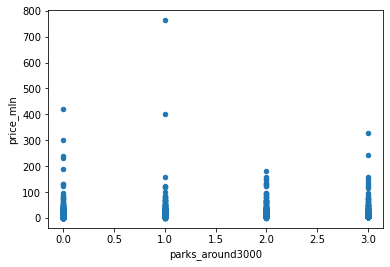

In [67]:
df.plot(x='parks_around3000', y='price_mln', kind='scatter')
plt.show()

In [68]:
df.groupby('parks_around3000')['price_mln'].median()

parks_around3000
0    4.1
1    5.4
2    5.9
3    7.3
Name: price_mln, dtype: float64

Фактическое влияние оказывает сам факт наличия водоема или парка (подъем на количестве "3" обусловлен ростом площади объектов, на цене квадратного метра рост не так значителен) 

**упростим ситуацию до "да/нет"**

#### Пруды:

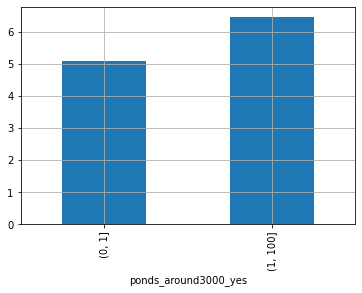

In [69]:
df['ponds_around3000_yes'] = pd.cut(df['ponds_around3000'], [0,1,100])
(
df.groupby('ponds_around3000_yes')['price_mln']
  .median()
  .plot(kind='bar', grid=True)
)
plt.show()

#### Парки:

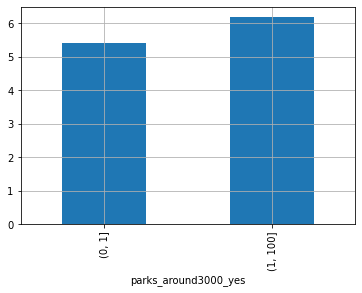

In [70]:
df['parks_around3000_yes'] = pd.cut(df['parks_around3000'], [0,1,100])
(
df.groupby('parks_around3000_yes')['price_mln']
  .median()
  .plot(kind='bar', grid=True)
)
plt.show()

In [71]:
df.groupby('ponds_around3000_yes')['price_mln'].median()

ponds_around3000_yes
(0, 1]      5.09
(1, 100]    6.45
Name: price_mln, dtype: float64

In [72]:
df.groupby('parks_around3000_yes')['price_mln'].median()

parks_around3000_yes
(0, 1]      5.400000
(1, 100]    6.177621
Name: price_mln, dtype: float64

#### Вывод:

In [73]:
print('Наличие пруда в радиусе 3-х километров увеличивает стоимость квартира на {:.0%}'.format((6325-5100)/5100))
print('Наличие парка в радиусе 3-х километров увеличивает стоимость квартира на {:.0%}'.format((6148-5400)/5400))

Наличие пруда в радиусе 3-х километров увеличивает стоимость квартира на 24%
Наличие парка в радиусе 3-х километров увеличивает стоимость квартира на 14%


### Высота потолков
Мы уже рассматривали влияние данного параметра на цену. Еще раз посмотрим на график из раздела "4.1 Параметры и гистограммы"

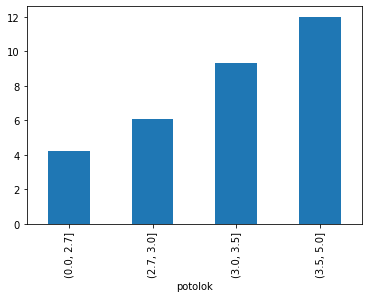

In [74]:
df.groupby('potolok')['price_mln'].median().plot(kind='bar')

In [75]:
df.groupby('potolok')['price_mln'].median()

potolok
(0.0, 2.7]     4.2
(2.7, 3.0]     6.1
(3.0, 3.5]     9.3
(3.5, 5.0]    12.0
Name: price_mln, dtype: float64

#### Вывод

Высокие потолки характеризуют объекты относящиеся к верхним ценовым сегментам (качественные характеристики здесь превалируют над стоимостью) отсюда и такой значимый рост. 
Так же высокие потолки могут расцениваться как  преимуществом и в масс-сегменте, если высота позволяет организовать двухуровневое размещение.

### Расстояние до центра
Мы уже рассматривали влияние данного параметра на цену. Еще раз посмотрим на график из раздела "4.1 Параметры и гистограммы"

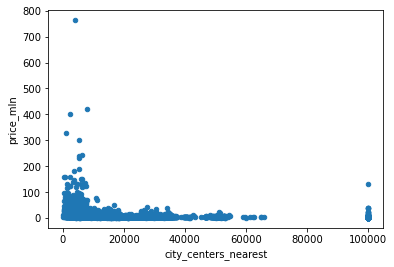

In [76]:
df.plot(x='city_centers_nearest', y='price_mln', kind='scatter')
plt.show()

In [77]:
df['centre'] = pd.cut(df['city_centers_nearest'], 
                      [0,1000,2000,3000,4000,5000,6000,7000,8000,9000, 10000, 11000, 12000,
                       13000, 14000, 15000, 20000, 30000, 40000, 50000, 1000000])

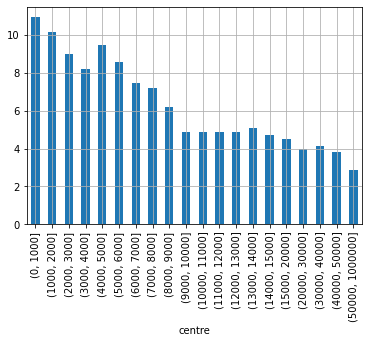

In [78]:
(df.groupby('centre')['price_mln']
   .median()
   .plot(kind='bar', grid=True)
)
plt.show()

### Вывод

Зависимость цены от расстояния до центра имеет ярко выраженную обратную зависимость. Из графика видно что границы зоны называемой центром проходят на отрезке 8-9 километров. Данный вопрос более подробно представлен в [Задание: "Центр"](#centre)

## Найдем зависимости от временных параметров:

In [79]:
data_2.corr()

,last_price,sq_price,days_exposition,weekday_exposition,month_exposition,year_exposition
last_price,1.000000,0.737186,0.079924,0.005245,0.006000,-0.059657
sq_price,0.737186,1.000000,0.047222,0.001961,0.006880,-0.009748
days_exposition,0.079924,0.047222,1.000000,-0.025253,-0.030572,-0.612034
weekday_exposition,0.005245,0.001961,-0.025253,1.000000,0.010618,0.008322
month_exposition,0.006000,0.006880,-0.030572,0.010618,1.000000,-0.198950
year_exposition,-0.059657,-0.009748,-0.612034,0.008322,-0.198950,1.000000


Данные корреляции неочевидны, рассмотрим их с помощью гистограмм

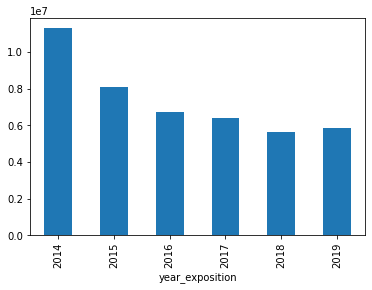

In [80]:
data_2.groupby('year_exposition')['last_price'].mean().plot(kind='bar')

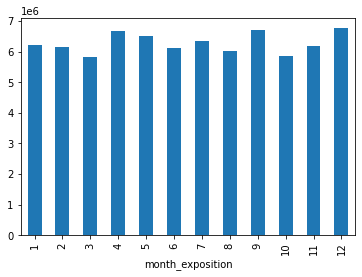

In [81]:
data_2.groupby('month_exposition')['last_price'].mean().plot(kind='bar')

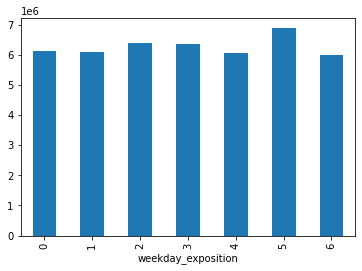

In [82]:
data_2.groupby('weekday_exposition')['last_price'].mean().plot(kind='bar')

### Вывод
Цена не имеет ярко выраженной сезонности и не зависит от дня недели в который было размещено объявление.

Цена квартиры зависит от года размещения. Зависимость соотноситься с глобальными рыночными тенденциями.


[к содержанию...](#title)

<a name="sq_meter"></a>
# 4.5 Задание "Средняя цена квадратного метра"

Согласно условиям задание сформируем ТОП-10 и проведем исследование:

In [83]:
top10 = df.groupby('locality_name')['sq_price'].agg(['count', 'mean'])
top10.columns = ['count', 'mean_sq_price']
(
top10.sort_values(by = 'count', ascending = False)
     .head(10)
     .sort_values(by = 'mean_sq_price', ascending = False)
)

,count,mean_sq_price
locality_name,,
Санкт-Петербург,13555,112362.437920
Пушкин,307,102074.188925
деревня Кудрово,299,92473.086957
посёлок Парголово,302,89504.615894
посёлок Мурино,513,85711.118908
посёлок Шушары,407,77872.137592
Колпино,308,74864.931818
Всеволожск,339,68570.150442
Гатчина,267,67938.026217


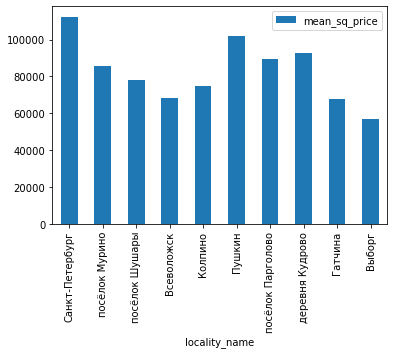

In [84]:
(
top10.sort_values(by = 'count', ascending = False)
     .head(10)
     .plot(y = 'mean_sq_price', kind = 'bar')
)
plt.show()

#### Вывод
**Наибольшая цена квадратного метра** ожидаемо принадлежит **Санкт-Петербургу** и составляет **112.36 тысяч рублей за 1 кв.м**.

Последние место в ТОП-10 с **минимальной ценой**  удерживает **Выборг** - **57.18 тысяч рублей за 1 кв.м**.

[к содержанию...](#title)

<a name="centre"></a>
# 4.6 Задание "Центр"
### Где же Центр?
Повысим эффективность кода, позволив себе слегка отклониться от легенды задания *(т.к. нет необходимости в создании новых столбцов и проведении дополнительных расчетов, к тому же у нас уже есть нарезанное на километры расстояние до центра.)*:


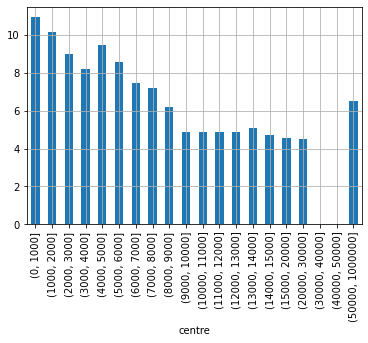

In [85]:
(df.query('locality_name == "Санкт-Петербург"')
   .groupby('centre')['price_mln']
   .median()
   .plot(kind='bar', grid=True, xlim=[0, 15])
)
plt.show()

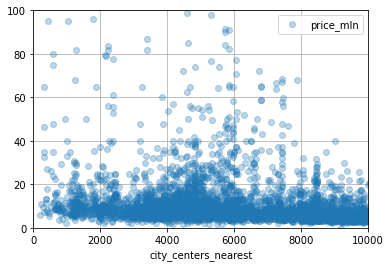

In [86]:
(df.query('locality_name == "Санкт-Петербург"')
.plot(x='city_centers_nearest', 
      y='price_mln',
      style='o',
      grid=True, 
      xlim=[0, 10000],
      ylim=[0, 100], alpha=0.3)
)

#### Вывод:
границы центра проходят по отметки 9 км.

### Анализ объектов зоны "Центр":
Проанализируем основные параметры и сравним их с общими выводами.

Изучаем параметры: 
- площадь, цена, число комнат, высота потолков. 

и факторы стоимости:
- число комнат, этаж, удалённость от центра, дата размещения объявления

In [87]:
work_columns_cntr = ['price_mln', 'sq_price','total_area', 'rooms', 'ceiling_height',
                     'locality_name', 'city_centers_nearest', 'floor_type', 'weekday_exposition',
                     'month_exposition', 'year_exposition']

In [88]:
df_cntr = df[work_columns_cntr].query('city_centers_nearest <= 9000')
df_cntr.head()

,price_mln,sq_price,total_area,rooms,ceiling_height,locality_name,city_centers_nearest,floor_type,weekday_exposition,month_exposition,year_exposition
2,64.9,408176,159.0,3,2.65,Санкт-Петербург,6800,other,4,7,2015
3,10.0,100000,100.0,2,3.03,Санкт-Петербург,8098,other,1,6,2018
22,6.5,66872,97.2,2,2.65,Санкт-Петербург,2336,first,5,10,2015
33,15.5,104026,149.0,5,2.65,Санкт-Петербург,3502,other,0,6,2017
45,45.0,279503,161.0,3,3.20,Санкт-Петербург,6589,other,1,10,2017


In [89]:
df_cntr.corr()

,price_mln,sq_price,total_area,rooms,ceiling_height,city_centers_nearest,weekday_exposition,month_exposition,year_exposition
price_mln,1.000000,0.797038,0.641569,0.349319,0.147051,-0.094623,0.021523,0.002951,-0.068983
sq_price,0.797038,1.000000,0.295796,0.047787,0.085631,-0.078051,0.021491,-0.005466,-0.031763
total_area,0.641569,0.295796,1.000000,0.755542,0.302405,-0.182800,0.007746,0.003802,-0.120787
rooms,0.349319,0.047787,0.755542,1.000000,0.268163,-0.235549,-0.006984,-0.003861,-0.102878
ceiling_height,0.147051,0.085631,0.302405,0.268163,1.000000,-0.277295,-0.049043,-0.002606,-0.012319
city_centers_nearest,-0.094623,-0.078051,-0.182800,-0.235549,-0.277295,1.000000,0.024050,-0.008486,0.072527
weekday_exposition,0.021523,0.021491,0.007746,-0.006984,-0.049043,0.024050,1.000000,0.039223,0.013228
month_exposition,0.002951,-0.005466,0.003802,-0.003861,-0.002606,-0.008486,0.039223,1.000000,-0.176666
year_exposition,-0.068983,-0.031763,-0.120787,-0.102878,-0.012319,0.072527,0.013228,-0.176666,1.000000


#### Предварительные наблюдения:
**Цена зависит от:** 
- sq_price 0.80
- total_area 0.64
- rooms 0.35
- ceiling_height 0.15
- city_centers_nearest -0.09


Для разнообразия и тренировки используем вместо describe(), самописную функцию:

In [90]:
def p_h_cntr(column):
    cntr_min = df_cntr[column].min()
    cntr_max = df_cntr[column].max()
    cntr_mean = df_cntr[column].mean()
    cntr_median = df_cntr[column].median()
    ttl_min = df[column].min()
    ttl_max = df[column].max()
    ttl_mean = df[column].mean()
    ttl_median = df[column].median()
    print('Минимальное значение общее: {:.1f}, центр: {:.1f}, отклонение: {:.0%}'.format(ttl_min, cntr_min, (cntr_min - ttl_min)/ttl_min ))
    print('Максимальное значение общее: {:.1f}, центр: {:.1f}, отклонение: {:.0%}'.format(ttl_max, cntr_max, (cntr_max - ttl_max)/ttl_max ))
    print('Среднее значение общее: {:.1f}, центр: {:.1f}, отклонение: {:.0%}'.format(ttl_mean, cntr_mean, (cntr_mean - ttl_mean)/ttl_mean ))
    print('Медиана общее: {:.1f}, центр: {:.1f}, отклонение: {:.0%}'.format(ttl_median, cntr_median, (cntr_median - ttl_median)/ttl_median ))

#### Площадь

In [91]:
p_h_cntr('total_area')

Минимальное значение общее: 12.0, центр: 12.0, отклонение: 0%
Максимальное значение общее: 900.0, центр: 900.0, отклонение: 0%
Среднее значение общее: 58.8, центр: 85.7, отклонение: 46%
Медиана общее: 50.8, центр: 72.0, отклонение: 42%


#### Вывод:
По сравнению с общими данными, квартиры в центре имеют большую на 46% среднюю площадь (в том числе выше и медиана)


#### Цена

In [92]:
df['price_mln'].describe()

count    20355.000000
mean         6.256058
std         10.854758
min          0.012190
25%          3.400000
50%          4.500000
75%          6.500000
max        763.000000
Name: price_mln, dtype: float64

In [93]:
p_h_cntr('price_mln')

Минимальное значение общее: 0.0, центр: 1.6, отклонение: 13026%
Максимальное значение общее: 763.0, центр: 763.0, отклонение: 0%
Среднее значение общее: 6.3, центр: 13.1, отклонение: 110%
Медиана общее: 4.5, центр: 8.4, отклонение: 87%


#### Вывод:
В среднем цена квартир в "центре" в 2 раза выше общей выборки. Это обусловлено как престижностью района, так и большей площадью объектов. Опять же квартиры данной зоны тяготят к премиум сегменту, а цена в нем уже перестает играть ключевую роль.


#### Число комнат

In [94]:
p_h_cntr('rooms')

Минимальное значение общее: 1.0, центр: 1.0, отклонение: 0%
Максимальное значение общее: 19.0, центр: 19.0, отклонение: 0%
Среднее значение общее: 2.0, центр: 2.7, отклонение: 31%
Медиана общее: 2.0, центр: 3.0, отклонение: 50%


Локации центр свойственны 3-х комнатные квартиры,

что касается цены, посмотрим ниже:

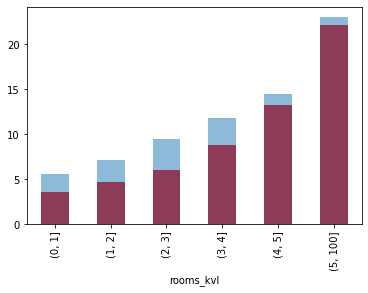

In [95]:
df_cntr['rooms_kvl'] = pd.cut(df['rooms'], [0,1,2,3,4,5,100])
df.groupby('rooms_kvl')['price_mln'].median().plot(kind='bar', color='r')
df_cntr.groupby('rooms_kvl')['price_mln'].median().plot(kind='bar', alpha=0.5)

plt.show()

#### Вывод:
В "центре преобладают 3-х комнатные квартиры, тогда как в общей выборке мы видим 2-х комнатные объекты. 

Увеличение стоимости в разрезе количества комнат обусловлено более высокой ценой квадратного метра. Уменьшение этой дельты в позициях: 5 и 5+ комнат вызвано тем, что основная масса объектов 5 и 5+ комнат как раз и расположены в центре.


#### Высота потолков

In [96]:
p_h_cntr('ceiling_height')

Минимальное значение общее: 2.2, центр: 2.4, отклонение: 9%
Максимальное значение общее: 5.0, центр: 4.9, отклонение: -2%
Среднее значение общее: 2.7, центр: 2.9, отклонение: 7%
Медиана общее: 2.6, центр: 2.7, отклонение: 2%


Вот строили же раньше...

**Посмотрим как дела с ценой**

In [97]:
df_cntr['potolok'] = pd.cut(df_cntr['ceiling_height'], (0,2.7,3,3.5,5))

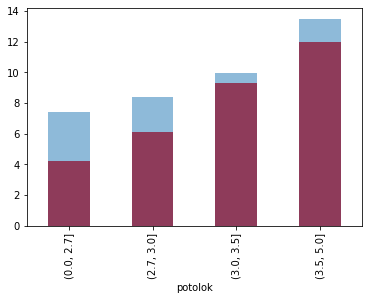

In [98]:
df.groupby('potolok')['price_mln'].median().plot(kind='bar', color='r')
df_cntr.groupby('potolok')['price_mln'].median().plot(kind='bar', alpha=0.5)

plt.show()

In [99]:
df_cntr.groupby('potolok')['price_mln'].agg(['count', 'mean'])

,count,mean
potolok,,
"(0.0, 2.7]",1840,11.373030
"(2.7, 3.0]",872,12.158240
"(3.0, 3.5]",769,16.024462
"(3.5, 5.0]",177,23.418768


#### Вывод:
Увеличение высоты потолков в "центре" обусловлено преобладанием исторической застройки и свойственным ей архитектурным традициям.

Анализ влияния данного параметра на цену объекта не входит в рамки данного задания, однако выводы и характер влияния полностью соответствует параметру - "количество комнат"


## Этажи

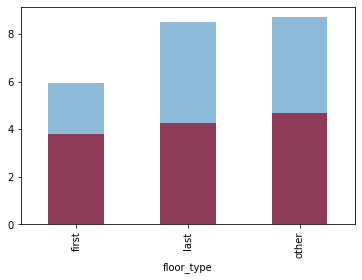

In [100]:
df.groupby('floor_type')['price_mln'].median().plot(kind='bar', color='r')
df_cntr.groupby('floor_type')['price_mln'].median().plot(kind='bar', alpha=0.5)

plt.show()

#### Вывод
Ну чтож, **первые этажи не любят даже в Центре)))**

В остальном разница в цене квадратного метра и большей площади объектов.

### "Расстояние до "центра в центре"


Разобьем "золотой километр" по 100 метров, а дальше по 500:

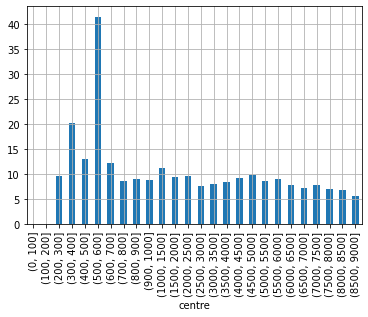

In [101]:
df_cntr['centre'] = pd.cut(df_cntr['city_centers_nearest'], 
                      [0,100,200,300,400,500,600,700,800,900, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000])
(df_cntr.query('locality_name == "Санкт-Петербург"')
   .groupby('centre')['price_mln']
   .median()
   .plot(kind='bar', grid=True, xlim=[0, 15])
)
plt.show()

Интересно, что же там такое на шестой сотне...

In [102]:
df_cntr.query('500 < city_centers_nearest < 600')

,price_mln,sq_price,total_area,rooms,ceiling_height,locality_name,city_centers_nearest,floor_type,weekday_exposition,month_exposition,year_exposition,rooms_kvl,potolok,centre
939,75.0,232198,323.0,5,4.00,Санкт-Петербург,594,other,0,7,2017,"(4, 5]","(3.5, 5.0]","(500, 600]"
4923,9.5,117283,81.0,2,2.65,Санкт-Петербург,515,other,1,5,2016,"(1, 2]","(0.0, 2.7]","(500, 600]"
6658,11.5,239583,48.0,1,3.70,Санкт-Петербург,583,other,5,12,2017,"(0, 1]","(3.5, 5.0]","(500, 600]"
7519,80.0,308641,259.2,5,3.30,Санкт-Петербург,573,other,4,5,2016,"(4, 5]","(3.0, 3.5]","(500, 600]"
9090,35.0,225806,155.0,4,2.50,Санкт-Петербург,573,other,6,11,2018,"(3, 4]","(0.0, 2.7]","(500, 600]"
10086,48.0,347322,138.2,3,2.65,Санкт-Петербург,591,other,2,4,2019,"(2, 3]","(0.0, 2.7]","(500, 600]"
15063,26.0,212418,122.4,4,2.65,Санкт-Петербург,537,last,4,8,2017,"(3, 4]","(0.0, 2.7]","(500, 600]"
16471,160.0,658436,243.0,5,2.65,Санкт-Петербург,555,other,0,11,2018,"(4, 5]","(0.0, 2.7]","(500, 600]"


### Вывод
Даже в центре есть свой центр и есть своя периферия)))

А вообще было бы интересно посмотреть удаленность от "достопримечательностей", можно предположить, что именно она объясняет колебания на графике... но у нас нет этих данных, а просто по карте не получилось зацепить логическую нить.

### Дата размещения объявления
Не совсем понятна логика этого запроса, но надо так надо...

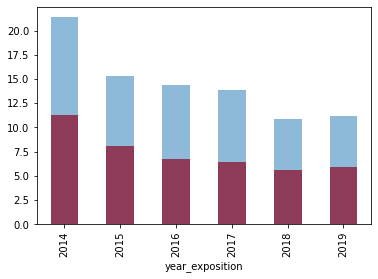

In [103]:
df.groupby('year_exposition')['price_mln'].mean().plot(kind='bar', color='r')
df_cntr.groupby('year_exposition')['price_mln'].mean().plot(kind='bar', alpha=0.5)

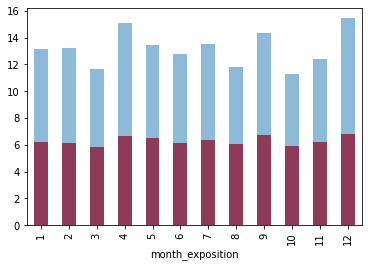

In [104]:
df.groupby('month_exposition')['price_mln'].mean().plot(kind='bar', color='r')
df_cntr.groupby('month_exposition')['price_mln'].mean().plot(kind='bar', alpha=0.5)

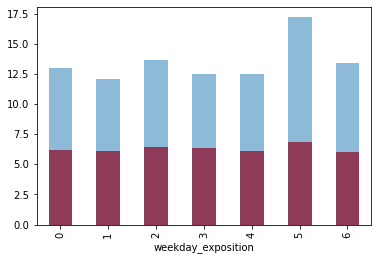

In [105]:
df.groupby('weekday_exposition')['price_mln'].mean().plot(kind='bar', color='r')
df_cntr.groupby('weekday_exposition')['price_mln'].mean().plot(kind='bar', alpha=0.5)

### Вывод
Оказалось это круто: 

1. Квартиры премиум сегмента продаются дороже если они выставлены в выходные
2. "Дешевая элитка" выставляется в октябре.


[к содержанию...](#title)

<a name="general"></a>
# 5. Общий вывод

Подведем итоги нашего проекта…

### Исходные данные, пропуски, дубликаты, типы данных:
В целом качество предоставленных данных можно оценить на 9 из 10. Критических отклонений и выбросов обнаружено не было.

В рамках работы был проведен анализ ряда параметров на предмет их реалистичности.
Проанализировав параметры:
- Площадь
- Цена
- Количество комнат
- Высота потолков
- Время продажи квартиры 
    
мы установили:

**1. Однозначной корректировке подлежат только значения в столбце "высота потолков".** Удаляем значения **менее 2.1** *(минимум по СНиП)* **и более 5 метров** *(для второго света в студии)*. Удаляем данные строки как явно ошибочные и незначительные в общем объеме (менее 50 строк).

**2. Значение параметров Цена, Количество комнат, Высота потолков** корректировки не подлежат.
**Их распределения логичны и имеют место быть в сфере недвижимости**.

Например: для "Площади" - **Сверхнизкие** *(доля в квартире)* и **сверхвысокие** *(12 комнатная квартира с бассейном на 400 кв.м)* 

**3. Распределение "Времени размещения"** соответствует **распределению Пуассона** на всем диапазоне значений (даже в максимальных точках). Относить максимальные значения к выбросам и исключать их из анализа будет некорректно. 

Так же в ходе анализа **установлено влияние** на данный показатель **географии** размещения объекта. Но в рамках имеющихся данных однозначные выводы сделать нельзя. 

Например: **пгт Форносово** может реально оказаться **"золотым" местом** где недвижимость разлетается как горячие пирожки. А вот **поселок Лисий нос** *(— конечная точка маршрута главного героя повести Даниила Хармса «Старуха»)* может и не пользоваться на рынке недвижимости популярностью.

### В рамках задания "Факторы стоимости квартиры, 
были установлены влияющие на стоимость величины:

**Цена квадратного метра** -  ожидаемая корреляция учитывая прямую связь этих параметров через площадь.  Квадратный метр в 3-4х комнатных квартирах всегда стоит меньше двушек и однушек, а далее наблюдаем резкий рост обусловленный переходом в премиум сегмент.

**Площадь** — Больше площадь, больше стоимость.

**Комнаты** — рассмотрев группы 1, 2, 3, 4, 5, 5+ комнат: мы обнаружили ярко выраженную зависимость обусловлена в первую очередь ростом площади объектов по мере роста количества комнат, усиливающуюся ростом цены квадратного метра по мере роста самой площади.

**Этажи** - Цена первого этажа ниже на -18%, цена последнего этажа ниже на -9%.

Классическая картина - "нехороших" квартир. Обычно в основные минусы первого и последнего этажа записывают безопасность, близость подвала и крыши. Фору последнему этажу дают освещенность, более свежий воздух и техэтаж в современных домах.

**Парки и пруды** - Фактическое влияние оказывает сам факт наличия водоема или парка, количество играет не так значительно.

Наличие пруда в радиусе 3-х километров увеличивает стоимость квартира на 24%

Наличие парка в радиусе 3-х километров увеличивает стоимость квартира на 14%

**Высота потолков** - Высокие потолки характеризуют объекты относящиеся к верхним ценовым сегментам (качественные характеристики здесь превалируют над стоимостью) отсюда и **значимый рост цены от высоты потолка**. Так же высокие потолки могут расцениваться как преимуществом и в масс-сегменте, если высота позволяет организовать двухуровневое размещение.

**Время размещения объявления** - 

**Цена** **не имеет** ярко выраженной **сезонности** и **не зависит от дня недели** в который было размещено объявление. 

Цена квартиры зависит от года размещения. Зависимость соотноситься с глобальными рыночными тенденциями.

Забегая чуть-чуть в перед были установлены интересные закономерности  по зоне «центр»:
    1. Квартиры премиум сегмента продаются дороже если они выставлены в выходные 
    2. "Дешевая элитка" выставляется в октябре.
    
### В рамках задания  "Средняя цена квадратного метра", 
были сделаны следующие выводы:

**Наибольшая цена квадратного метра** ожидаемо принадлежит **Санкт-Петербургу** и составляет **112.36 тысяч рублей за 1 кв.м**.

Последние место в ТОП-10 с **минимальной ценой**  удерживает **Выборг** - **57.18 тысяч рублей за 1 кв.м**.

### Расстояние до центра - 
Зависимость цены от расстояния до центра имеет ярко выраженную обратную зависимость. 

Мы установили, что **границы зоны** называемой **центром** проходят на отрезке **9 километров**.

Мы рассмотрели основные параметры для этой зоны и сравнили их с общими выводами.


**Площадь** - По сравнению с общими данными, квартиры в центре имеют большую на 46% среднюю площадь (в том числе выше и медиана)

**Цена** — в среднем цена квартир в "центре" в 2 раза выше общей выборки. Это обусловлено как престижностью района, так и большей площадью объектов. Опять же квартиры данной зоны тяготят к премиум сегменту, а цена в нем уже перестает играть ключевую роль.

**Число комнат** -  в "центре преобладают 3-х комнатные квартиры, тогда как в общей выборке мы видим 2-х комнатные объекты.
Увеличение стоимости в разрезе количества комнат обусловленно более высокой ценой квадратного метра. Уменьшение этой дельты в позициях: 5 и 5+ комнат вызвано тем, что основная масса объетов 5 и 5+ комнат как раз и расположены в центре.

**Высота потолков** - Увеличение высоты потолков в "центре" обусловленно преоблоданием исторической застройки и свойственным ей архитектурным традициям.
Анализ влияния данного параметра на цену объекта не входит в рамки данного задания, однако выводы и характер влияния полностью соответствует параметру - "количество комнат"

**Этажи** — увеличение стоимости соответствует разнице в цене квадратного метра и большей площади объектов. Исключение составляют первые этажи, которые как и общей выборке не пользуются популярностью.

**"Расстояние до "центра в центре"** - даже в центре есть свой центр это зона до 500 метров, где цена явно превалирует на остальной зоной.

А вообще было бы интересно посмотреть удаленность от "достопримечательностей", можно предположить, что именно она объясняет колебания на графике... но у нас нет этих данных, а просто по карте не получилось зацепить логическую нить.

[к содержанию...](#title)